<b>Machine Learning I / Mini Lab Predictive Analysis</b>
<br><b>Authors:</b> Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
<br><b>Data set from:</b> https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

After our initial Exploratory Data Analysis (EDA) project, we needed to pick a model that would predict if a patient would have cardiovascular disease based on the variables available in our data.  These are:  gender, systolic blood pressure, diastolic blood pressure, age, height and weight (which we used to calculate Body Mass Index or BMI), a cholesterol level indicator, a glucose level indicator, and indicators to identify if a patient used alcohol, smoked or was active.    You can view the full descriptions of these data elements in our EDA document.
<br>  

During our EDA, we determined that the factors that had the highest level of correlation to cardiovascular disease were:   Blood pressure, BMI, Age, Cholesterol and Glucose.     However, we didn’t want to limit ourselves to only these.   So, we ran five combinations of these variables.  For each combination of variables, we ran both SVM and Logistical Regression models.  For each combination and method, we ran with scaled data and non-scaled data.   Our findings are documented below.


# Setup

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline

df = pd.read_csv("cardio_train.csv", sep=";")



# Clean data

In [27]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2




In [28]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bp,bmi
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,Hyper_Stage2,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,Hyper_Stage1,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,Hyper_Stage2,28.710479
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,Hyper_Stage1,29.384676
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,Hyper_Stage1,37.729725


In [29]:
if 'cardio' in df:
    y = df['cardio'].values
    X = df[['bmi','age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','bp']]

# Model Variable Selection Options

1. 'ap_hi' (highest co-relation)
2. 'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
3. 'bmi', 'age', ‘bp’, 'cholesterol'
4. ‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol'
5. 'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active', 'weight' (all variable)



some more explanation

## train test split

In [30]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model (ap_hi only)

### Not Scaled

In [31]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.72824882 0.73408985 0.72698812]


### Scaled

In [32]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73003831 0.72809101 0.73499662]


## SVM using BMI, age, ap_hi, ap_lo, cholesterol

### Not Scaled

In [33]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.6984536  0.69656515 0.70801481]


### Scaled

In [9]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.76840956 0.77169696 0.77709315]


# Hyperparameter Tuning

In [10]:
from sklearn.model_selection import GridSearchCV

### SVM

In [11]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',


In [12]:
clf.best_params_

{'classifier__alpha': 0.05,
 'classifier__loss': 'modified_huber',
 'classifier__penalty': 'l1'}

In [13]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


Best auc: 0.776048 using {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.771162 (0.004277) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.775388 (0.000386) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.774222 (0.001181) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.775637 (0.001584) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.775440 (0.001362) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.773793 (0.001210) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776048 (0.001007) with: {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.775198 (0.00

## Probability Calibration

In [14]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.78613973 0.7757698  0.77987763]


## ROC

SVM Model ROC AUC=0.784


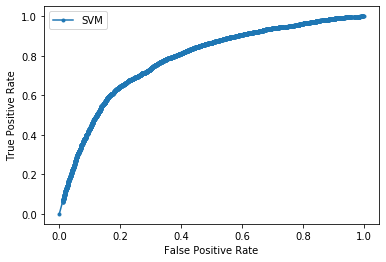

In [15]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [16]:
svm_probs

array([0.75631208, 0.38823115, 0.71325091, ..., 0.7279005 , 0.53458465,
       0.84903442])

In [17]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))


alpha 0.000000 : accuracy=0.565
alpha 0.100000 : accuracy=0.565
alpha 0.200000 : accuracy=0.565
alpha 0.300000 : accuracy=0.601
alpha 0.400000 : accuracy=0.699
alpha 0.500000 : accuracy=0.715
alpha 0.600000 : accuracy=0.683
alpha 0.700000 : accuracy=0.610
alpha 0.800000 : accuracy=0.544
alpha 0.900000 : accuracy=0.493


### tune a little finer

In [18]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



alpha 0.400000 : accuracy=0.699
alpha 0.410000 : accuracy=0.707
alpha 0.420000 : accuracy=0.714
alpha 0.430000 : accuracy=0.719
alpha 0.440000 : accuracy=0.721
alpha 0.450000 : accuracy=0.724
alpha 0.460000 : accuracy=0.724
alpha 0.470000 : accuracy=0.721
alpha 0.480000 : accuracy=0.717
alpha 0.490000 : accuracy=0.717
alpha 0.500000 : accuracy=0.715
alpha 0.510000 : accuracy=0.716
alpha 0.520000 : accuracy=0.716
alpha 0.530000 : accuracy=0.713
alpha 0.540000 : accuracy=0.712
alpha 0.550000 : accuracy=0.710
alpha 0.560000 : accuracy=0.706
alpha 0.570000 : accuracy=0.703
alpha 0.580000 : accuracy=0.697
alpha 0.590000 : accuracy=0.688


## Support Vector Analysis

In [34]:
    
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']].values
cv_object =  ShuffleSplit(n_splits=1,
                         test_size  = 0.9)

#train test split
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    scl_obj = StandardScaler()
    scl_obj.fit(X_train)
    
    X_train_scaled = scl_obj.transform(X_train)
    X_test_scaled = scl_obj.transform(X_test) 
        

# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
    
# make a dataframe of the training data
df_tested_on = df.iloc[train_indices].copy() # saved from above, the indices chosen for training

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['cardio'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['cardio'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3532 entries, 36103 to 32906
Data columns (total 15 columns):
id             3532 non-null int64
age            3532 non-null int64
gender         3532 non-null int64
height         3532 non-null int64
weight         3532 non-null float64
ap_hi          3532 non-null int64
ap_lo          3532 non-null int64
cholesterol    3532 non-null int64
gluc           3532 non-null int64
smoke          3532 non-null int64
alco           3532 non-null int64
active         3532 non-null int64
cardio         3532 non-null int64
bp             3532 non-null category
bmi            3532 non-null float64
dtypes: category(1), float64(2), int64(12)
memory usage: 417.6 KB


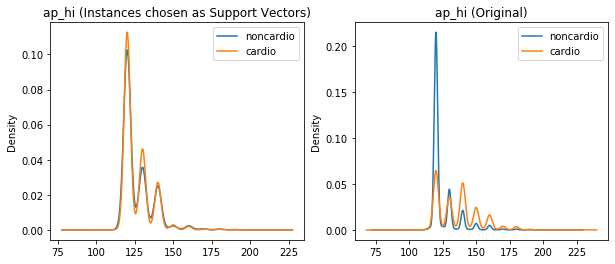

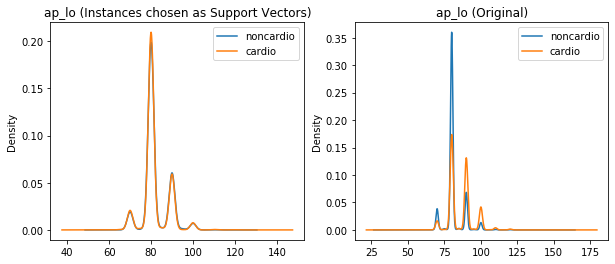

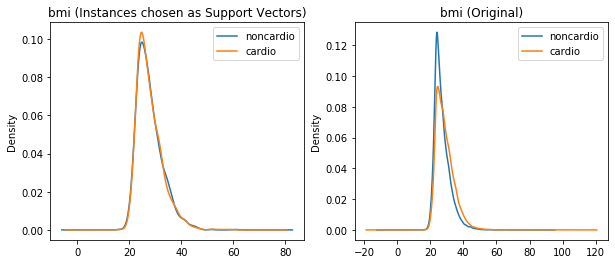

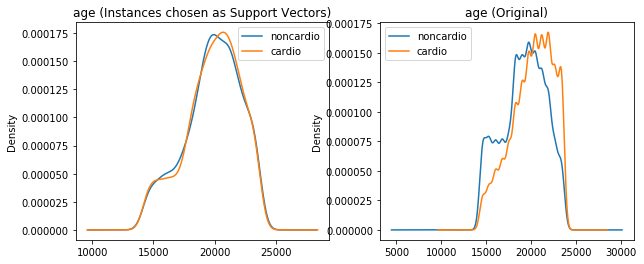

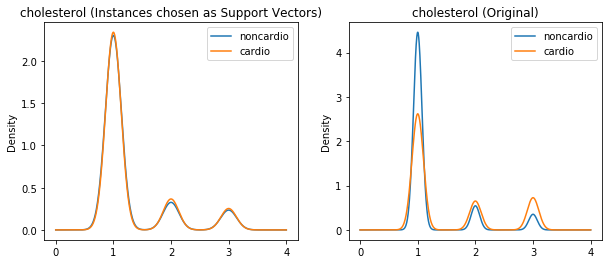

In [36]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df.groupby(['cardio'])

# plot KDE of Different variables
 
vars_to_plot =['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']

for v in vars_to_plot:
    pyplot.figure(figsize=(10,4))
    # plot support vector stats
    pyplot.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    pyplot.legend(['noncardio','cardio'])
    pyplot.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    pyplot.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    pyplot.legend(['noncardio','cardio'])
    pyplot.title(v+' (Original)')




The graphs on the left show the support vectors which are the points on the SVM borders.  These are compared to the graphs on the right which show the distribution of the response variable classes. The above graphs show that the support vectors are distributed in a similar manner between the cardio and non-cardio classes of the response variable. The original distribution shows the uneven distribution of the response variable for each predictor.

### Logistic Regression

 There are multiple parameters that can help build a Logistic  Regression model listed below with the default value.  


*(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None])*



However, our team decided to focus on few critical in tuning process like C, solver and penalty. 



Hyperparameters sets the algorithm that can be adjusted to optimize performance, these are the knobs to generate optimal outcome. These Hyperparameters in machine learning model help define your model architecture. Leveraging grid search optimal automated exploration is launched to find the optimal parameter value to extract best model architecture. 

The project Grid search approach was used to tune the parameters of the model. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. However, grid search suffers from the curse of dimensionality: the number of times required to evaluate the model during hyperparameter optimization grows exponentially in the number of parameters. 

The other popular method is Random Search. It is performed by evaluating n uniformly random points in the hyperparameter space and select the one producing the best performance. The drawback of random search is unnecessarily high variance. The method is, after all, entirely random, and uses no intelligence in selecting which points to try. You are relying on luck to get good results.

In the model building excises Grid Search was used and to overcome the curse of dimensionality hyper parameter list was highly evaluated and one making maxim impact were chosen. The model tuning process three parameters were considered, C, penalty and Solver. 

<b>C:</b> This control the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decrease which impels the model is allowed to increase it's complexity, and therefore, overfit the data. 

<b>Penalty:</b> This project uses two penalties. Li and L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables.
Lasso (L1) performs feature selection by shrinking the less important feature’s coefficient to zero.
Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso.
Both penalty values restrict solver choices. It is critical to choose the right combination of Penalty.



<b>Solver:</b> Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. other possible values (to list few) are, liblinear, sag and saga.
liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes.
lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty.
saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty.
sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.



<b>Ref:</b> 
https://sigopt.com/blog/common-problems-in-hyperparameter-optimization

https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d





### Options
Following are combo I selected based on high correlation and removing

'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
'ap_hi' (highest co-relation)
'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)

In [50]:
#df
# option 1'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
y = df['cardio'].values # get the labels we want
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']].values 

### Option 1 model

In [51]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [52]:
#make a grid search for logistic regression


param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)



GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
    

In [53]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773116 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773116 (0.002880) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.772888 (0.002898) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773002 (0.002888) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.772938 (0.002751) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.772882 (0.002820) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.630876 (0.013919) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.630864 (0.013911) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.718578 (0.075957) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.630862 (0.013909) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.630861 (0.013909) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [54]:

from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object


In [55]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7721223577925707
confusion matrix
 [[3389 1345]
 [1709 4168]]
====Iteration 1  ====
auc 0.778856436172594
confusion matrix
 [[3358 1277]
 [1733 4243]]
====Iteration 2  ====
auc 0.7807018195077647
confusion matrix
 [[3389 1284]
 [1733 4205]]


#### train test split

In [56]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

#### Logistic Regression Scaled

In [57]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [58]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.0874455 , 0.25032902, 0.09042533, 0.25449506, 0.10305691,
        0.2407252 , 0.09773866, 0.26962789, 0.10338942, 0.23919535,
        0.06034184, 0.24136249, 0.19797436, 0.0659941 , 0.29073739,
        0.21625932, 0.07714009, 0.28193712, 0.19431718, 0.062838  ,
        0.28441087, 0.20439378, 0.06433169, 0.27733048, 0.1988159 ]),
 'std_fit_time': array([0.009278  , 0.01670778, 0.00169484, 0.03871999, 0.00994721,
        0.01727578, 0.00990589, 0.02331441, 0.00682958, 0.01163524,
        0.00107339, 0.02625819, 0.00323569, 0.005909  , 0.03917264,
        0.00864367, 0.01089561, 0.03348519, 0.01243686, 0.00070104,
        0.02728363, 0.01467126, 0.00361472, 0.02780758, 0.01444982]),
 'mean_score_time': array([0.00630442, 0.00565171, 0.00631698, 0.00598605, 0.00930834,
        0.00664878, 0.00698153, 0.00731611, 0.00864673, 0.00664862,
        0.0058291 , 0.00698113, 0.00731428, 0.007646  , 0.00598303,
        0.00664743, 0.00830698, 0.00563447, 0.00631698, 0.00

In [59]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.779314 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.779310 (0.001561) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.779314 (0.001560) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.779302 (0.001563) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.779303 (0.001563) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.779301 (0.001563) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.779303 (0.001562) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.779301 (0.001564) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.779301 (0.001563) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.779301 (0.001564)

In [185]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7749714293946777
[0.71020639 0.71114881 0.7135991 ]


In [60]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7734904512340969
confusion matrix
 [[3392 1356]
 [1741 4122]]
====Iteration 1  ====
auc 0.7785666899692981
confusion matrix
 [[3395 1280]
 [1715 4221]]
====Iteration 2  ====
auc 0.7748519473379081
confusion matrix
 [[3370 1237]
 [1773 4231]]


In [61]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [62]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [63]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [64]:
model=clf.best_estimator_.fit(X,y)

In [65]:
model.named_steps["classifier"].coef_

array([[0.10075748, 0.89574721, 0.12861305, 0.28285532, 0.2972742 ]])

#### precision recall curve

Logistic: ROC AUC=0.775


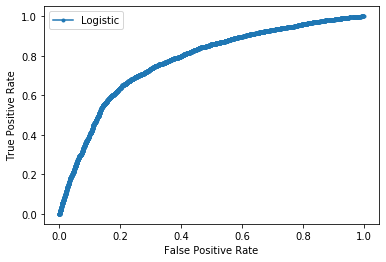

In [66]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Option 3 model

In [86]:
y = df['cardio'].values # get the labels we want
X = df[['bmi','age','ap_lo','ap_hi','cholesterol','gluc','smoke','alco','active']].values 

In [87]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)



C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
     

In [89]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773890 using {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773810 (0.002036) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773890 (0.002113) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773799 (0.001920) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.773749 (0.002115) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.773727 (0.002034) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.638009 (0.019738) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638005 (0.019738) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638005 (0.019737) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.643108 (0.024449) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.643417 (0.024173) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [90]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773890 using {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773810 (0.002036) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773890 (0.002113) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773799 (0.001920) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.773749 (0.002115) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.773727 (0.002034) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.638009 (0.019738) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638005 (0.019738) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.638005 (0.019737) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.643108 (0.024449) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.643417 (0.024173) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [92]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [93]:
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [94]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7794605020809389
confusion matrix
 [[3330 1273]
 [1759 4249]]
====Iteration 1  ====
auc 0.7741226188961596
confusion matrix
 [[3312 1256]
 [1773 4270]]
====Iteration 2  ====
auc 0.7850293482230004
confusion matrix
 [[3380 1254]
 [1683 4294]]


#### train test split

In [95]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

#### Logistic Regression Scaled

### Hyper Parameter Tuning

In [96]:
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.07646195, 0.1755294 , 0.07280493, 0.20245846, 0.06881571,
        0.16456   , 0.075797  , 0.19581024, 0.07213918, 0.19015861,
        0.04920204, 0.20877473, 0.12932054, 0.04720736, 0.20545038,
        0.18916059, 0.04355049, 0.21608877, 0.18583512, 0.04953448,
        0.24668574, 0.15757791, 0.04853717, 0.25265805, 0.17187317]),
 'std_fit_time': array([0.00448497, 0.01525451, 0.00423121, 0.02280137, 0.00244279,
        0.02280105, 0.00861726, 0.01965093, 0.00328657, 0.01506747,
        0.00338958, 0.03184535, 0.01018141, 0.00417878, 0.0100068 ,
        0.00878389, 0.00094055, 0.01608842, 0.03176219, 0.00409966,
        0.02736744, 0.00325767, 0.00188054, 0.01739524, 0.0136832 ]),
 'mean_score_time': array([0.00465616, 0.00398914, 0.00398954, 0.00398922, 0.00365718,
        0.00398938, 0.00432165, 0.0043211 , 0.00465306, 0.00398874,
        0.00432142, 0.00399009, 0.00365678, 0.00465393, 0.00432173,
        0.00465385, 0.00398906, 0.00398938, 0.00432189, 0.00

In [97]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.775825 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775822 (0.002132) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775825 (0.002133) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775797 (0.002118) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775798 (0.002118) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775797 (0.002117) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775796 (0.002116) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775795 (0.002116) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.775796 (0.002117) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.775795 (0.002116)

In [98]:

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7850952388413968
[0.70558854 0.71652059 0.72528508]


In [99]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7810925926647668
confusion matrix
 [[3382 1262]
 [1755 4212]]
====Iteration 1  ====
auc 0.7799067000694215
confusion matrix
 [[3418 1291]
 [1742 4160]]
====Iteration 2  ====
auc 0.772200156160928
confusion matrix
 [[3349 1310]
 [1733 4219]]


In [100]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [101]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [102]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [103]:
model=clf.best_estimator_.fit(X,y)

In [104]:
model.named_steps["classifier"].coef_

array([[ 0.10182943,  0.29566252,  0.12966723,  0.90210574,  0.32371619,
        -0.07848243, -0.03661676, -0.0482337 , -0.09433658]])

#### precision recall curve

Logistic: ROC AUC=0.772


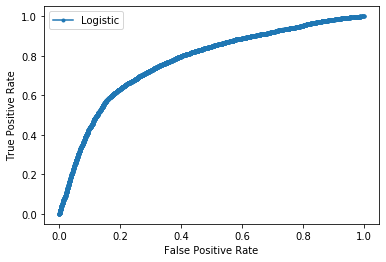

In [105]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##### The following is the summary of Analysis that was run on Logistic Regression and SVM with Five options in unscaled and scaled options.

The chart below shows the comparison of all models we ran on AUC score.   We are showing the results of the more significant models in the main body of this notebook, and have included the models of less interest in the Appendix.

We compared all models both with and without scaling the data.  

The highest performing model for Logistic Regression, per AUC, was Option 3, which included all variables.   A very close score was obtained for Option 1, which included: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.   Since these Option 1 variables were our most significant variables per our Exploratory Data Analysis, we chose Option 1 as our preferred model.  For these Logistical Regression models, scaling the data did not seem to help.

The highest performing model for SVM was option 1 with the variables described above.   In this case, scaling the data did make a difference.

Our primary model is Logistic Regression, unscaled data with the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

Our backup/ secondary model is SVM with scaled data and the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

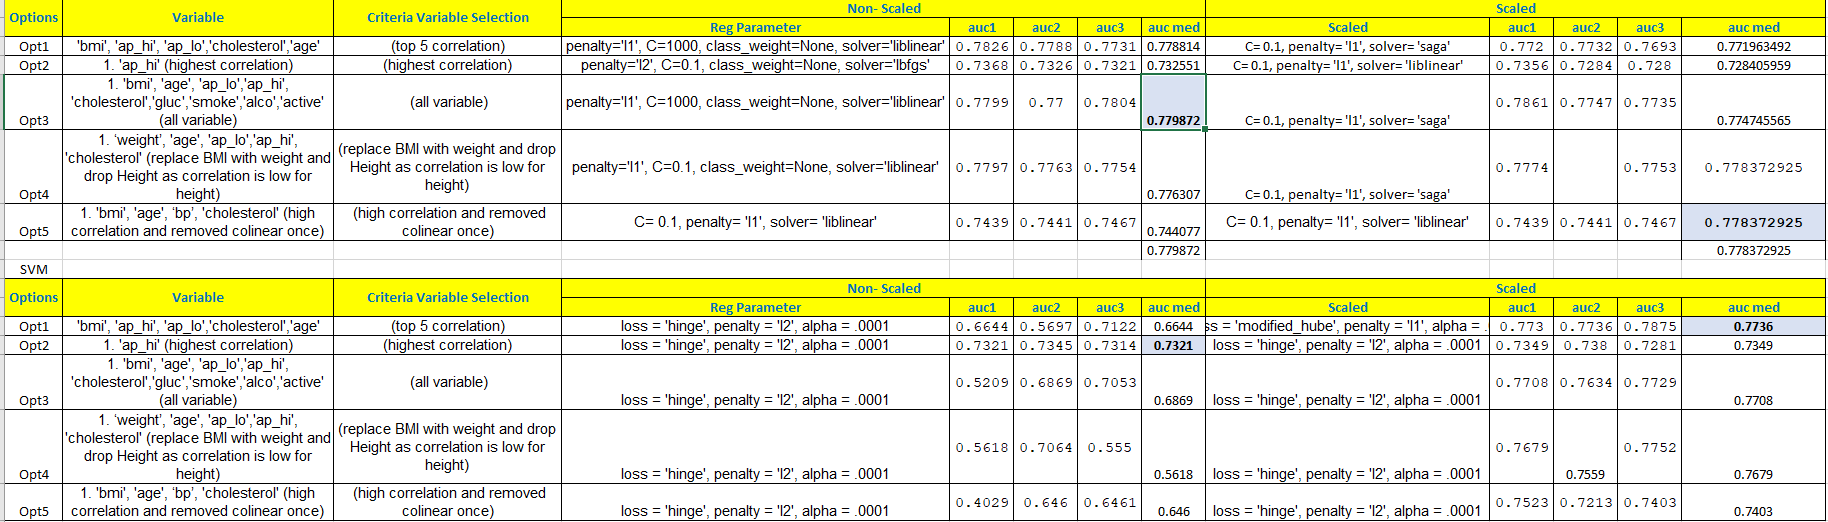

# SVM

Our favorite SVM model is Option 1 Scaled

Confusion matrix / classification report  - Ellen

precision, recall, f1, accuracy - Ellen

explain the hyperparameters - Tina

### Interpretation

Make SVC from subsampled set - Tina

Ellen

# Logistic regression

Our favorite Logistic model is Option 1 Unscaled

Confusion matrix / classification report 

precision, recall, f1, accuracy

explain the hyperparameters - Paritosh, Fabio

### Weights Interpretation

Fabio

# Advantages and Disadvantages

Our favorite model overall is the Logistic regression option 1 unscaled.

Is one better about training time?

Is one better from accuracy?

# Appendix

## Decision Tree Model

In [286]:
df=df_clean
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bp,bmi
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,Hyper_Stage2,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,Hyper_Stage1,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,Hyper_Stage2,28.710479
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,Hyper_Stage1,29.384676
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,Hyper_Stage1,37.729725


In [288]:
from sklearn.model_selection import train_test_split
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']]
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [289]:
"""#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)
"""

'#make CV spit 80/20 object\n\nnum_cv_iterations = 3\nnum_instances = len(y)\ncv_object = ShuffleSplit(n_splits=num_cv_iterations,\n                         test_size  = 0.2)\n                         \nprint(cv_object)\n'

#### Training a Decision Tree Model
Let's start by training a single decision tree first!

** Import DecisionTreeClassifier**

In [290]:
from sklearn.tree import DecisionTreeClassifier

Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.

In [291]:
dtree = DecisionTreeClassifier()

In [295]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### Predictions and Evaluation of Decision Tree

Create predictions from the test set and create a classification report and a confusion matrix

In [296]:
predictions = dtree.predict(X_test)

In [297]:
from sklearn.metrics import classification_report,confusion_matrix

In [298]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      4679
           1       0.67      0.67      0.67      5932

    accuracy                           0.63     10611
   macro avg       0.62      0.62      0.62     10611
weighted avg       0.63      0.63      0.63     10611



In [299]:

from sklearn import metrics as mt
auc = mt.roc_auc_score(y_test,predictions)
print("auc", auc )

auc 0.6237689612430226


### Training the Random Forest model
Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [300]:
from sklearn.ensemble import RandomForestClassifier

In [301]:
rfc = RandomForestClassifier(n_estimators=600)

In [303]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Predictions and Evaluation
Let's predict off the y_test values and evaluate our model.

** Predict the class of not.fully.paid for the X_test data.**

In [304]:
predictions = rfc.predict(X_test)

Now create a classification report from the results.

In [305]:
from sklearn.metrics import classification_report,confusion_matrix

In [306]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      4679
           1       0.71      0.73      0.72      5932

    accuracy                           0.68     10611
   macro avg       0.68      0.68      0.68     10611
weighted avg       0.68      0.68      0.68     10611



## The following Logistical Regression Models were rejected, but they were not far in accuracy and AUC scores from the preferred model.

### Option 2   AP_HI variable only (systolic blood pressure).  With unscaled data

In [124]:
# option 2  systolic blood pressure
y = df['cardio'].values  
X = df[['ap_hi','ap_lo']].values 

In [125]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs', 'sag', 'saga']},
 ]


lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
 
clf.fit(X, y)


C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'sag', '

In [127]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.740140 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.740140 (0.000425) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.740134 (0.000422) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.740134 (0.000422) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.740134 (0.000422) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.740134 (0.000422) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.740133 (0.000423) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720740 (0.002420) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.714955 (0.002202) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.740133 (0.000423) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720740 (0.002420) with: {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
0.714955 (0.002202) with: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
0.740133 (0.000423) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720746 (0.002428) with: {'C': 10, 'penalty': 

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='lbfgs' ) # get object




In [129]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7384463339135359
confusion matrix
 [[3464 1287]
 [1875 3985]]
====Iteration 1  ====
auc 0.7313864985197328
confusion matrix
 [[3437 1302]
 [1924 3948]]
====Iteration 2  ====
auc 0.7332941820985637
confusion matrix
 [[3371 1242]
 [1915 4083]]


### train test split

In [130]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [42]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [43]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.0325791 , 0.07116469, 0.02892232, 0.0730962 , 0.03889481,
        0.0545187 , 0.0279146 , 0.06483905, 0.03257958, 0.06748637,
        0.02127663, 0.07280533, 0.06948074, 0.01762009, 0.11470334,
        0.09506663, 0.0169553 , 0.0887622 , 0.05784512, 0.02393643,
        0.08477259, 0.05053147, 0.01562421, 0.09341677, 0.07446869]),
 'std_fit_time': array([0.0032912 , 0.01220755, 0.00354928, 0.01957796, 0.01345487,
        0.00680523, 0.00244313, 0.00923087, 0.00124277, 0.00981776,
        0.0012439 , 0.00960049, 0.01541438, 0.0032915 , 0.02268182,
        0.03235604, 0.00293731, 0.00453496, 0.00508453, 0.00373092,
        0.01355328, 0.00773932, 0.00308316, 0.01727902, 0.01129311]),
 'mean_score_time': array([0.00432173, 0.00363588, 0.00233873, 0.00265988, 0.00432158,
        0.00399113, 0.0033346 , 0.00398763, 0.00432165, 0.00465401,
        0.00265988, 0.00265956, 0.00365671, 0.00365694, 0.00564011,
        0.0049866 , 0.00398938, 0.00299207, 0.0039889 , 0.00

In [44]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.734673 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.005731) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.005731) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.005731) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.00

In [45]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.7327580506037955
[0.70587127 0.69503346 0.70530581]


In [46]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7392666949100711
confusion matrix
 [[3453 1206]
 [1905 4047]]
====Iteration 1  ====
auc 0.7323875924914998
confusion matrix
 [[3444 1238]
 [1934 3995]]
====Iteration 2  ====
auc 0.7273072261367277
confusion matrix
 [[3440 1286]
 [1945 3940]]


In [47]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [48]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [49]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [50]:
model=clf.best_estimator_.fit(X,y)

In [51]:
model.named_steps["classifier"].coef_

array([[1.09443405]])

### precision recall curve

Logistic: ROC AUC=0.727


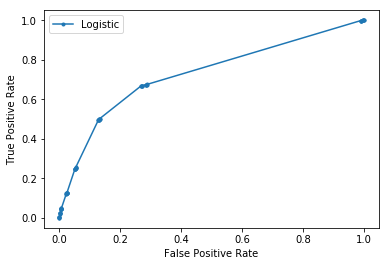

In [52]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Scaling

### Logistic Regression Scaled

### Hyper Parameter Tuning 

In [69]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.0867784 , 0.19680611, 0.09707483, 0.20843832, 0.08710074,
        0.23805221, 0.08577061, 0.22979315, 0.08510574, 0.19846845,
        0.0468746 , 0.2081097 , 0.17187405, 0.0588429 , 0.26696332,
        0.16589936, 0.04654225, 0.23171298, 0.16057134, 0.06151366,
        0.18784165, 0.15691241, 0.04688811, 0.23803997, 0.16389434]),
 'std_fit_time': array([0.00803452, 0.03944448, 0.02067177, 0.02817772, 0.01924246,
        0.01225835, 0.00081624, 0.0336347 , 0.00896927, 0.02378397,
        0.00635917, 0.0363652 , 0.01964279, 0.0078523 , 0.03987367,
        0.01483394, 0.00094117, 0.00983122, 0.00695654, 0.02439465,
        0.00878869, 0.02823671, 0.00588624, 0.02971557, 0.01459726]),
 'mean_score_time': array([0.00664981, 0.00598502, 0.00797757, 0.00398938, 0.00432142,
        0.00396641, 0.00797892, 0.00464328, 0.00531896, 0.00465504,
        0.00498676, 0.00364582, 0.00365655, 0.00565076, 0.00564138,
        0.00398986, 0.00571744, 0.00399065, 0.00498629, 0.00

In [70]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.777607 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777606 (0.001708) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777607 (0.001709) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777585 (0.001702) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777585 (0.001702) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777583 (0.001701) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777582 (0.001701) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777582 (0.001701) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777583 (0.001702) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777582 (0.001701)

In [71]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.7786511652363493
[0.71265668 0.71199698 0.71623787]


In [72]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7773814507479797
confusion matrix
 [[3361 1293]
 [1725 4232]]
====Iteration 1  ====
auc 0.7734876054094295
confusion matrix
 [[3313 1292]
 [1712 4294]]
====Iteration 2  ====
auc 0.7798040522052846
confusion matrix
 [[3402 1324]
 [1699 4186]]


In [73]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [74]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [75]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [76]:
model=clf.best_estimator_.fit(X,y)

In [77]:
model.named_steps["classifier"].coef_

array([[ 0.29565621,  0.9020981 ,  0.1296683 ,  0.3236999 , -0.07848062,
        -0.03665095, -0.04820689, -0.09434821,  0.10183709]])

### precision recall curve

Logistic: ROC AUC=0.780


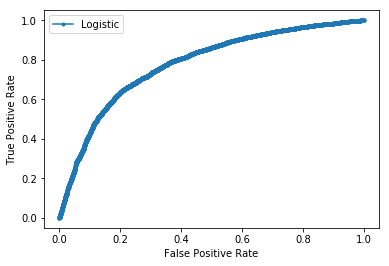

In [78]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



### Option 4

In [79]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [80]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [81]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [82]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [83]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [84]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [85]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [86]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [87]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','gluc','smoke','alco','active','cardio','bmi','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 4 model

In [88]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [89]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_






{'mean_fit_time': array([0.58977667, 0.61006085, 0.50205167, 0.66789786, 0.62170815,
        0.23470434, 0.16256507, 0.14594237, 0.1791877 , 0.16256571]),
 'std_fit_time': array([0.14277105, 0.12323054, 0.06742446, 0.12424486, 0.14168672,
        0.11365907, 0.02684776, 0.02407847, 0.02394067, 0.0355976 ]),
 'mean_score_time': array([0.00361983, 0.00462731, 0.00363   , 0.00498184, 0.00395195,
        0.00698217, 0.00365702, 0.00498676, 0.00465393, 0.00664822]),
 'std_score_time': array([4.67968739e-04, 9.58724525e-04, 4.85599762e-04, 2.17114763e-03,
        7.80211418e-06, 8.13322746e-04, 9.39425201e-04, 2.15405697e-03,
        1.24273209e-03, 1.24328429e-03]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [90]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.774747 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774747 (0.002167) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774615 (0.002159) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774688 (0.002107) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.774652 (0.002227) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.774684 (0.002225) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.628749 (0.016055) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.669711 (0.075832) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.616423 (0.001405) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.616423 (0.001405) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.616423 (0.001405) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object




In [92]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7829777782643877
confusion matrix
 [[3402 1285]
 [1742 4182]]
====Iteration 1  ====
auc 0.77953422780246
confusion matrix
 [[3366 1317]
 [1697 4231]]
====Iteration 2  ====
auc 0.7747743403872166
confusion matrix
 [[3349 1325]
 [1708 4229]]


### train test split

In [93]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [94]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [95]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.08809757, 0.13563728, 0.06482752, 0.16489116, 0.07480113,
        0.14961012, 0.06216677, 0.15092953, 0.05485304, 0.17256172,
        0.04654177, 0.16123454, 0.11635526, 0.03590242, 0.18483822,
        0.13430683, 0.03324374, 0.20578257, 0.15159082, 0.04055818,
        0.19380649, 0.15458751, 0.04986604, 0.21110177, 0.15325602]),
 'std_fit_time': array([0.03218648, 0.01485994, 0.00924807, 0.03804149, 0.01216045,
        0.04236068, 0.00470067, 0.01793922, 0.00293634, 0.02788303,
        0.00835811, 0.01477766, 0.01192058, 0.00162811, 0.0333917 ,
        0.01265079, 0.00046997, 0.00954353, 0.02492565, 0.00308274,
        0.02732095, 0.04044341, 0.01447601, 0.01186529, 0.01681352]),
 'mean_score_time': array([0.00565147, 0.0036575 , 0.00432118, 0.00365742, 0.00398898,
        0.00364661, 0.0043215 , 0.00531912, 0.00365702, 0.00529559,
        0.00365678, 0.0053196 , 0.00398978, 0.00532039, 0.00399025,
        0.00531896, 0.00332483, 0.00631698, 0.00465369, 0.00

In [96]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.781336 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781334 (0.002621) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781336 (0.002621) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781326 (0.002616) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781326 (0.002616) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781325 (0.002615) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781324 (0.002615) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781324 (0.002615) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781325 (0.002615) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781323 (0.002614)

In [97]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.774929622251729
[0.71124305 0.71209123 0.70907549]


In [98]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7753158137417063
confusion matrix
 [[3353 1340]
 [1733 4185]]
====Iteration 1  ====
auc 0.7755508656370104
confusion matrix
 [[3434 1287]
 [1762 4128]]
====Iteration 2  ====
auc 0.7724583962001766
confusion matrix
 [[3362 1318]
 [1747 4184]]


In [99]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [100]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [101]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [102]:
model=clf.best_estimator_.fit(X,y)

In [103]:
model.named_steps["classifier"].coef_

array([[0.30249373, 0.09140337, 0.8996206 , 0.12844921, 0.28637318]])

### precision recall curve

Logistic: ROC AUC=0.772


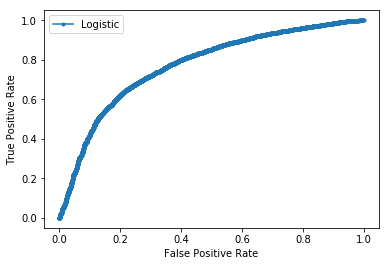

In [104]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()




### Option 5

In [105]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [106]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [107]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [108]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [109]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [110]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [111]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [112]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [113]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 5 model

In [114]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [115]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.28792159, 0.3982842 , 0.34011745, 0.27063163, 0.29957183,
        0.02470827, 0.02825872, 0.02491188, 0.03523866, 0.03025254]),
 'std_fit_time': array([0.02944319, 0.03942984, 0.08878178, 0.03130499, 0.03117728,
        0.00250116, 0.00248755, 0.00162936, 0.00971533, 0.00692428]),
 'mean_score_time': array([0.0029579 , 0.00430473, 0.00362992, 0.00496467, 0.00361713,
        0.0032169 , 0.0046525 , 0.00332411, 0.00432165, 0.00299136]),
 'std_score_time': array([3.22428747e-06, 4.81892504e-04, 4.74639717e-04, 8.28353901e-04,
        9.35435760e-04, 5.61182179e-04, 2.35229991e-03, 4.68617012e-04,
        1.88070479e-03, 1.32507737e-06]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
LogisticRegression()
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object




In [117]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.6545841722217853
confusion matrix
 [[ 321 4334]
 [ 157 5799]]
====Iteration 1  ====
auc 0.6576116009160325
confusion matrix
 [[ 256 4415]
 [ 154 5786]]
====Iteration 2  ====
auc 0.6506144107276153
confusion matrix
 [[ 403 4267]
 [ 275 5666]]


### train test split

In [118]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [119]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [120]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.03557197, 0.08942699, 0.04489152, 0.10970656, 0.04089117,
        0.0997328 , 0.02991954, 0.0930829 , 0.04255311, 0.11668921,
        0.02760235, 0.11135689, 0.10040871, 0.03058624, 0.13398631,
        0.07944194, 0.02359223, 0.12234012, 0.1090529 , 0.03292378,
        0.17496681, 0.10039862, 0.03058441, 0.15358957, 0.078789  ]),
 'std_fit_time': array([0.00308246, 0.00448607, 0.00775783, 0.0171591 , 0.01272123,
        0.00906804, 0.00081459, 0.01164095, 0.00339056, 0.00614811,
        0.00515952, 0.01110522, 0.01970331, 0.00417954, 0.02376628,
        0.01262173, 0.0012312 , 0.01301187, 0.01477985, 0.00734337,
        0.02226991, 0.01186713, 0.00542353, 0.00564352, 0.0048851 ]),
 'mean_score_time': array([0.00432221, 0.00398938, 0.00563947, 0.00531912, 0.00365655,
        0.00565219, 0.00365734, 0.00398993, 0.00433334, 0.00564988,
        0.0056502 , 0.00299287, 0.00431061, 0.00598327, 0.00432189,
        0.00465322, 0.00400066, 0.00365686, 0.00564019, 0.00

In [121]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.743912 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743912 (0.000528) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743912 (0.000528) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.000528) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743911 (0.000528) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.000528) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743911 (0.000528) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.000528) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743911 (0.000528) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.00

In [122]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.7333350033357999
[0.69983979 0.70483461 0.70210159]


In [123]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7449583077169937
confusion matrix
 [[3178 1483]
 [1636 4314]]
====Iteration 1  ====
auc 0.7403036835573813
confusion matrix
 [[3123 1522]
 [1641 4325]]
====Iteration 2  ====
auc 0.7442072616685852
confusion matrix
 [[3157 1549]
 [1602 4303]]


In [124]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [125]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [126]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [127]:
model=clf.best_estimator_.fit(X,y)

In [128]:
model.named_steps["classifier"].coef_

array([[0.34692142, 0.18307629, 0.79513794]])

### precision recall curve

Logistic: ROC AUC=0.744


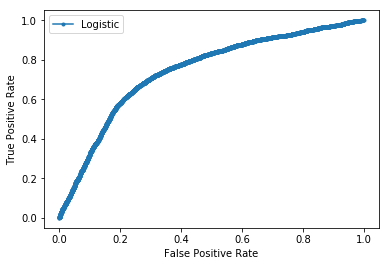

In [129]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()